In [1]:
pip install arabic-reshaper python-bidi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import matplotlib.font_manager as fm
import time
import arabic_reshaper
from bidi.algorithm import get_display
import openpyxl
from openpyxl.utils import get_column_letter
from openpyxl import Workbook
from openpyxl.styles import PatternFill, Alignment

In [3]:
# Function to support arabic formatting
def fix_arabic(text):
    reshaped_text = arabic_reshaper.reshape(text) # Reshape Arabic text for proper display to avoid issues with character joining
    bidi_text = get_display(reshaped_text) # Convert to displayable format that supports right-to-left languages
    return bidi_text

In [4]:
excel_file='studentcourses.xlsx'
dfs=pd.read_excel(excel_file,sheet_name=None,engine='openpyxl')
dfs=pd.concat(dfs.values(),ignore_index=True)

In [5]:
dfs.head(10)

,رقم الطالب,اسم الطالب,التخصص,رقم المقرر,اسم المقرر,رمز المقرر,رقم الشعبة
0,1105312002,عبدالمجيد علي عبدالرحمن الشاوي,السجلات الطبية-2,110501,المهارات اللغوية,ARAB 101,211637
1,1105311013,سالم سليمان دهش الشمري,السجلات الطبية-2,110501,المهارات اللغوية,ARAB 101,211637
2,1105312004,احمد عبدالله صالح الحربي,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,111647
3,1105321021,يوسف عبدالله سليمان المهوس,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,211647
4,1105312011,سطام بندر جايز المطيري,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,211647
5,1105312009,مشاري فهيد محمد المطيري,السجلات الطبية-2,110511,التحرير العربي,ARAB 102,211647
6,1105312004,احمد عبدالله صالح الحربي,السجلات الطبية-2,110507,Biology,BIOL 101,111643
7,1105312002,عبدالمجيد علي عبدالرحمن الشاوي,السجلات الطبية-2,110518,النظام الإقتصادي في الإسلام,ISLM 103,111654
8,1105301020,فهد عبدالعالي محمد المطيري,السجلات الطبية-2,110509,English Language 2,ENGL 102,111645
9,1105312001,ايوب عابد علي النخلي,السجلات الطبية-2,110509,English Language 2,ENGL 102,111645


**Clean The Data**

In [6]:
dfs.isnull().sum()    # Check how many missing values per column

رقم الطالب    0
اسم الطالب    0
التخصص        0
رقم المقرر    0
اسم المقرر    0
رمز المقرر    0
رقم الشعبة    0
dtype: int64

In [7]:
dfs.drop_duplicates(inplace=True)
print(dfs["اسم المقرر"].nunique)

<bound method IndexOpsMixin.nunique of 0        المهارات اللغوية
1        المهارات اللغوية
2          التحرير العربي
3          التحرير العربي
4          التحرير العربي
               ...       
11383     هندسة البرمجيات
11384     هندسة البرمجيات
11385     هندسة البرمجيات
11386     هندسة البرمجيات
11387     هندسة البرمجيات
Name: اسم المقرر, Length: 11104, dtype: object>


In [8]:
print(dfs.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11104 entries, 0 to 11387
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   رقم الطالب  11104 non-null  object
 1   اسم الطالب  11104 non-null  object
 2   التخصص      11104 non-null  object
 3   رقم المقرر  11104 non-null  object
 4   اسم المقرر  11104 non-null  object
 5   رمز المقرر  11104 non-null  object
 6   رقم الشعبة  11104 non-null  object
dtypes: object(7)
memory usage: 694.0+ KB
None


**Build a graph using network**

Time taken for largest_first strategy: 0.0000 seconds
Number of colors used in largest_first strategy: 20
Time taken for smallest_last strategy: 0.0227 seconds
Number of colors used in smallest_last strategy: 20
Time taken for random_sequential strategy: 0.0000 seconds
Number of colors used in random_sequential strategy: 23
Time taken for independent_set strategy: 0.8479 seconds
Number of colors used in independent_set strategy: 26


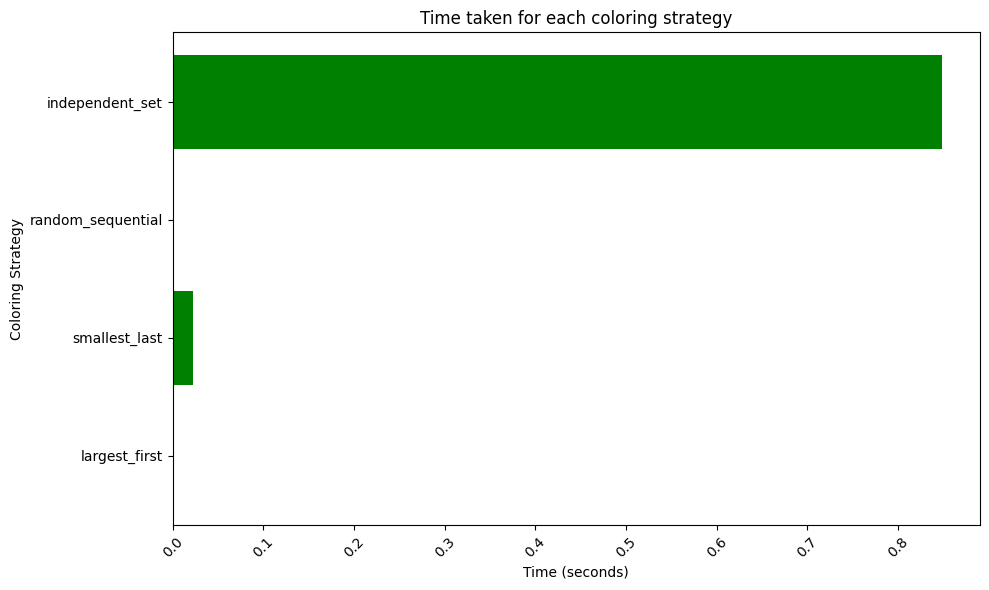

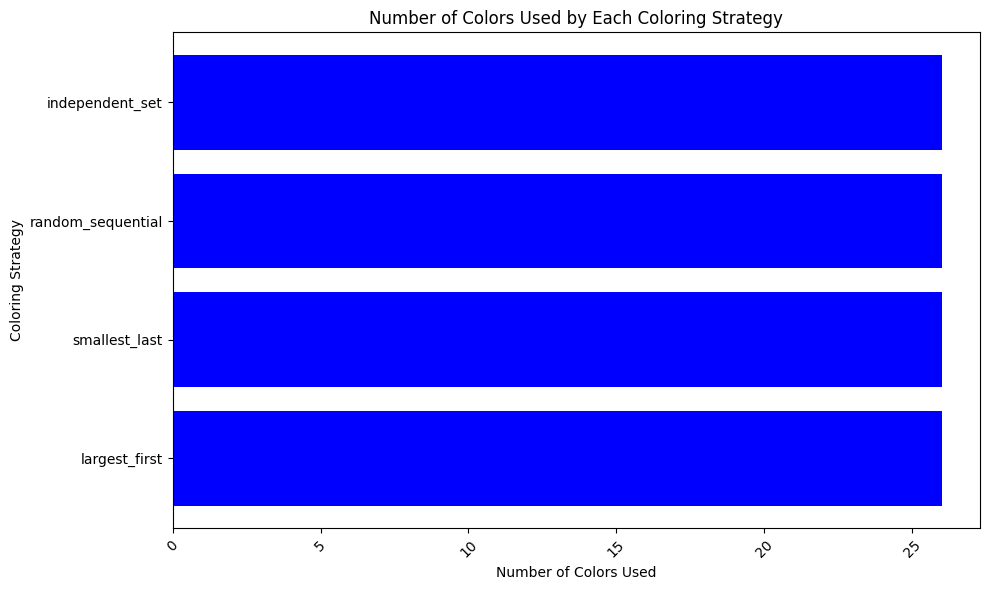

In [ ]:
# Create a graph and add edges/nodes
G = nx.Graph()

# Make a list of each student's courses
students = dfs.groupby("رقم الطالب")["اسم المقرر"].apply(list)

# Add Edges and Nodes
for course_list in students:
    course_list = list(set(course_list))  # Remove duplicated courses
    reshaped = [fix_arabic(course) for course in course_list]
    for i in range(len(reshaped)):
        for j in range(i+1, len(reshaped)):
            if G.has_edge(reshaped[i], reshaped[j]):
                G[reshaped[i]][reshaped[j]]["weight"] += 1
            else:
                G.add_edge(reshaped[i], reshaped[j], weight=1)

Coloring_strategies=['largest_first', 'smallest_last' ,'random_sequential', 'independent_set']
# 'largest_first': directly starts with nodes of highest degree.
# 'smallest_last': removes nodes of lowest degree, and colors in reverse, so high-degree nodes end up later.
# 'random_sequential': colors nodes in random order, which can lead to less optimal coloring.
# 'independent_set': colors nodes based on independent sets (set of nodes with no edges between them), All nodes in one independent set can get the same color

time_per_strategy = {}
num_colors = {}

for strategy in Coloring_strategies:
    start_time = time.time()
    color_map = nx.coloring.greedy_color(G, strategy=strategy)
    end_time = time.time()

    Time = end_time - start_time
    time_per_strategy[strategy] = Time
    print(f"Time taken for {strategy} strategy: {Time:.4f} seconds")

    num_colors[strategy] = len(set(color_map.values()))
    print(f"Number of colors used in {strategy} strategy: {num_colors[strategy]}")

# Compare the time taken for each strategy by plotting
plt.figure(figsize=(10, 6))
plt.barh(time_per_strategy.keys(), time_per_strategy.values(), color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Coloring Strategy')
plt.title('Time taken for each coloring strategy')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

# Compare the number of colors used by each strategy
num_colors = {strategy: len(set(color_map.values())) for strategy in Coloring_strategies}
plt.figure(figsize=(10, 6)) 
plt.barh(num_colors.keys(), num_colors.values(), color='blue')
plt.xlabel('Number of Colors Used')
plt.ylabel('Coloring Strategy')
plt.title('Number of Colors Used by Each Coloring Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

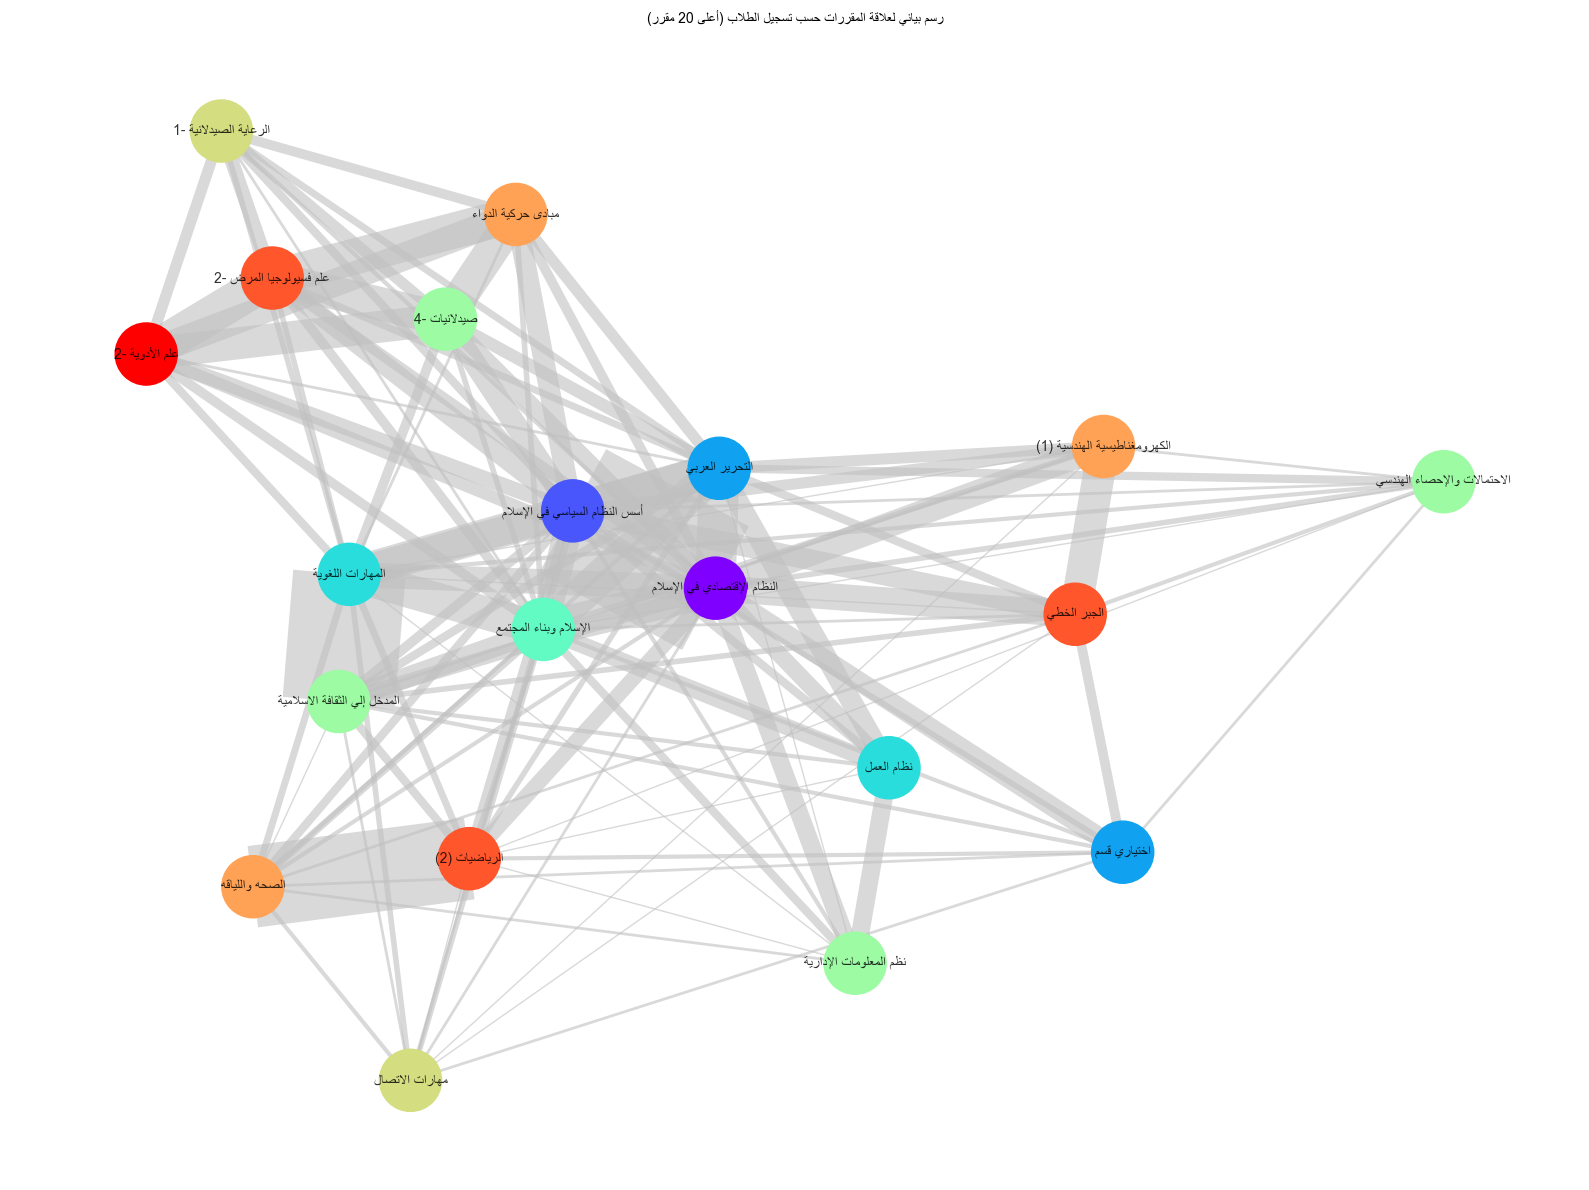

In [23]:
# Apply greedy coloring (ensure no adjacent courses share the same color) using the largest_first strategy
coloring = nx.coloring.greedy_color(G, strategy="largest_first")

# Get the 20 most connected nodes (courses) based on their degree
top_20_courses = sorted(G.degree, key=lambda x: x[1], reverse=True)[:20]
top_20_courses = [course for course, degree in top_20_courses]

# Subgraph for the top 20 courses
subgraph = G.subgraph(top_20_courses)

# Visualize the Graph with the coloring applied for the top 20 courses
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(subgraph, k=0.7) # spread nodes with distance=0.7

# Color nodes based on their assigned color
node_colors = [coloring[node] for node in subgraph.nodes]

# Draw nodes with the appropriate colors
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=2000, cmap=plt.cm.rainbow)

# Draw edges with varying width based on weight
edges = subgraph.edges()
weights = [subgraph[u][v]["weight"] for u, v in edges]
nx.draw_networkx_edges(subgraph, pos, width=weights, alpha=0.6, edge_color="silver")

# Draw labels with Arabic text support
labels = {node: node for node in subgraph.nodes}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_family='Arial', alpha=0.8)

# Title with Arabic text support
plt.title(fix_arabic("رسم بياني لعلاقة المقررات حسب تسجيل الطلاب (أعلى 20 مقرر)"), fontsize=100, fontproperties=fm.FontProperties(family='Arial'))
plt.axis("off")
plt.tight_layout()
plt.show()


In [24]:
# Print the number of nodes
print("Number of nodes:", G.number_of_nodes())

# Print the number of edges
print("Number of edges:", G.number_of_edges())


Number of nodes: 461
Number of edges: 5267


**Define Rooms**

In [30]:
# Example: Dictionary for examination rooms and their capacities
Rooms_capacity = {
    "Room 401": 15,
    "Room 402": 100,
    "Room 403": 200,
    "Room 404": 150,
    "Room 405": 100,
    "Room 406": 200,
    "Room 407": 150,
    "Room 408": 100,
    "Room 409": 100,
    "Room 410": 120,
    "Room 411": 90,
    "Room 412": 200,
    "Room 413": 180,
    "Room 414": 170,
    "Room 415": 150,
    "Room 416": 200,
    "Room 417": 200,
    "Room 418": 100,
    "Room 419": 120,
    "Room 420": 110,
}
# Get student counts per course
course_counts = dfs.groupby("اسم المقرر")["رقم الطالب"].nunique().to_dict()

# Assign each course to a room and get its capacity
course_room = {}

for course, color in coloring.items():
    # Get the student count for the course
    student_count = course_counts.get(course, 1)

    # Find the room that has enough capacity for the course
    assigned_room = None
    for room, capacity in Rooms_capacity.items():
        if student_count <= capacity:  # If the student count fits the committee's capacity
            assigned_room = room
            Rooms_capacity[room] -= student_count  # Reduce the available capacity
            break

    # If no committee has enough capacity, we assign to the committee with the least remaining capacity
    # if assigned_room is None:
    #     assigned_room = min(Rooms_capacity, key=Rooms_capacity.get)
    #     Rooms_capacity[assigned_room] -= student_count

    # Store the committee assignment
    course_room[course] = assigned_room


**Create Exams Schedule Excel File**

In [33]:
# From Greedy coloring algorithm , we detect that:
# Each color = One exam time slot
# No two connected courses (shared students) can be at the same time.

# Organize courses by color (time slot)
slots_per_day = 4
slot_labels = [
    "الفترة الصباحية الأولى",
    "الفترة الصباحية الثانية",
    "الفترة المسائية الأولى",
    "الفترة المسائية الثانية"
]

# Make dictionary {course: color_number}
color_groups = {}
for course, color in coloring.items():
    color_groups.setdefault(color, []).append(course)

# Start writing to Excel
wb = Workbook() # creates a new Excel workbook.
ws = wb.active # access the default active worksheet
ws.title = "جدول الامتحانات"

row = 1

for color in sorted(color_groups):
    day = color // slots_per_day + 1  # Calculate the day number based on the current color and the number of slots per day
    period_index = color % slots_per_day # Determine the period index for the current color (remainder of division by slots per day)
    period_label = slot_labels[period_index] # Get the label for the current period based on the period index


    # Header section:

    # Define the color fill for header cells
    header_fill = PatternFill(start_color="ADD8E6", end_color="ADD8E6", fill_type="solid")  # Light Blue for headers


     # Merge cells for the "Day" header (spanning 3 columns) and insert the day number in Arabic
    ws.merge_cells(start_row=row, start_column=1, end_row=row, end_column=3)
    day_cell=ws.cell(row=row, column=1, value=f"اليوم رقم: {day}")
    day_cell.fill = header_fill  # Apply color to the header cell
    row += 1

     # Merge cells for the "Period" header (spanning 3 columns) and insert the period label in Arabic
    ws.merge_cells(start_row=row, start_column=1, end_row=row, end_column=3)
    period_cell=ws.cell(row=row, column=1, value=f"الفترة: {period_label}")
    period_cell.fill = header_fill  # Apply color to the header cell
    row += 1

     # Merge cells for the "Course List" header (spanning 3 columns) and insert the header text
    ws.merge_cells(start_row=row, start_column=1, end_row=row, end_column=3)
    course_list_cell=ws.cell(row=row, column=1, value="مقررات الفترة")
    course_list_cell.fill = header_fill  # Apply color to the header cell
    row += 1

     # Add a separator line
    ws.merge_cells(start_row=row, start_column=1, end_row=row, end_column=3)
    ws.cell(row=row, column=1, value="*" * 50)
    row += 2

    # Define fill for column headers
    column_header_fill = PatternFill(start_color="90EE90", end_color="90EE90", fill_type="solid")  # Light Green

    # Column headers with color
    ws.cell(row=row, column=1, value="اسم المقرر").fill = column_header_fill
    ws.cell(row=row, column=2, value="العدد").fill = column_header_fill
    ws.cell(row=row, column=3, value="اللجنة").fill = column_header_fill

    row += 1

    # Iterate over each course in the current color (period)
    for course in color_groups[color]:
        count = course_counts.get(course, 1) # Get courses with at least 1 student

        # Retrieve the assigned room for the course
        room = course_room.get(course, "غير محدد")

        ws.cell(row=row, column=1, value=fix_arabic(course))
        ws.cell(row=row, column=2, value=count)
        ws.cell(row=row, column=3, value=room)
        row += 1

    row += 2  # Space between periods

# Adjust column width and center alignment
for col in range(1, 4):
    ws.column_dimensions[get_column_letter(col)].width = 30
    for cell in ws[get_column_letter(col)]:
        cell.alignment = Alignment(horizontal="center")

# Save Excel file
output_path = "جدول_الامتحانات_منسق.xlsx"
wb.save(output_path)
print(f"Schedule saved to '{output_path}' with 4 periods per day.")


Schedule saved to 'جدول_الامتحانات_منسق.xlsx' with 4 periods per day.


**Show Top 100 Courses According To Number Of Students Assigned**

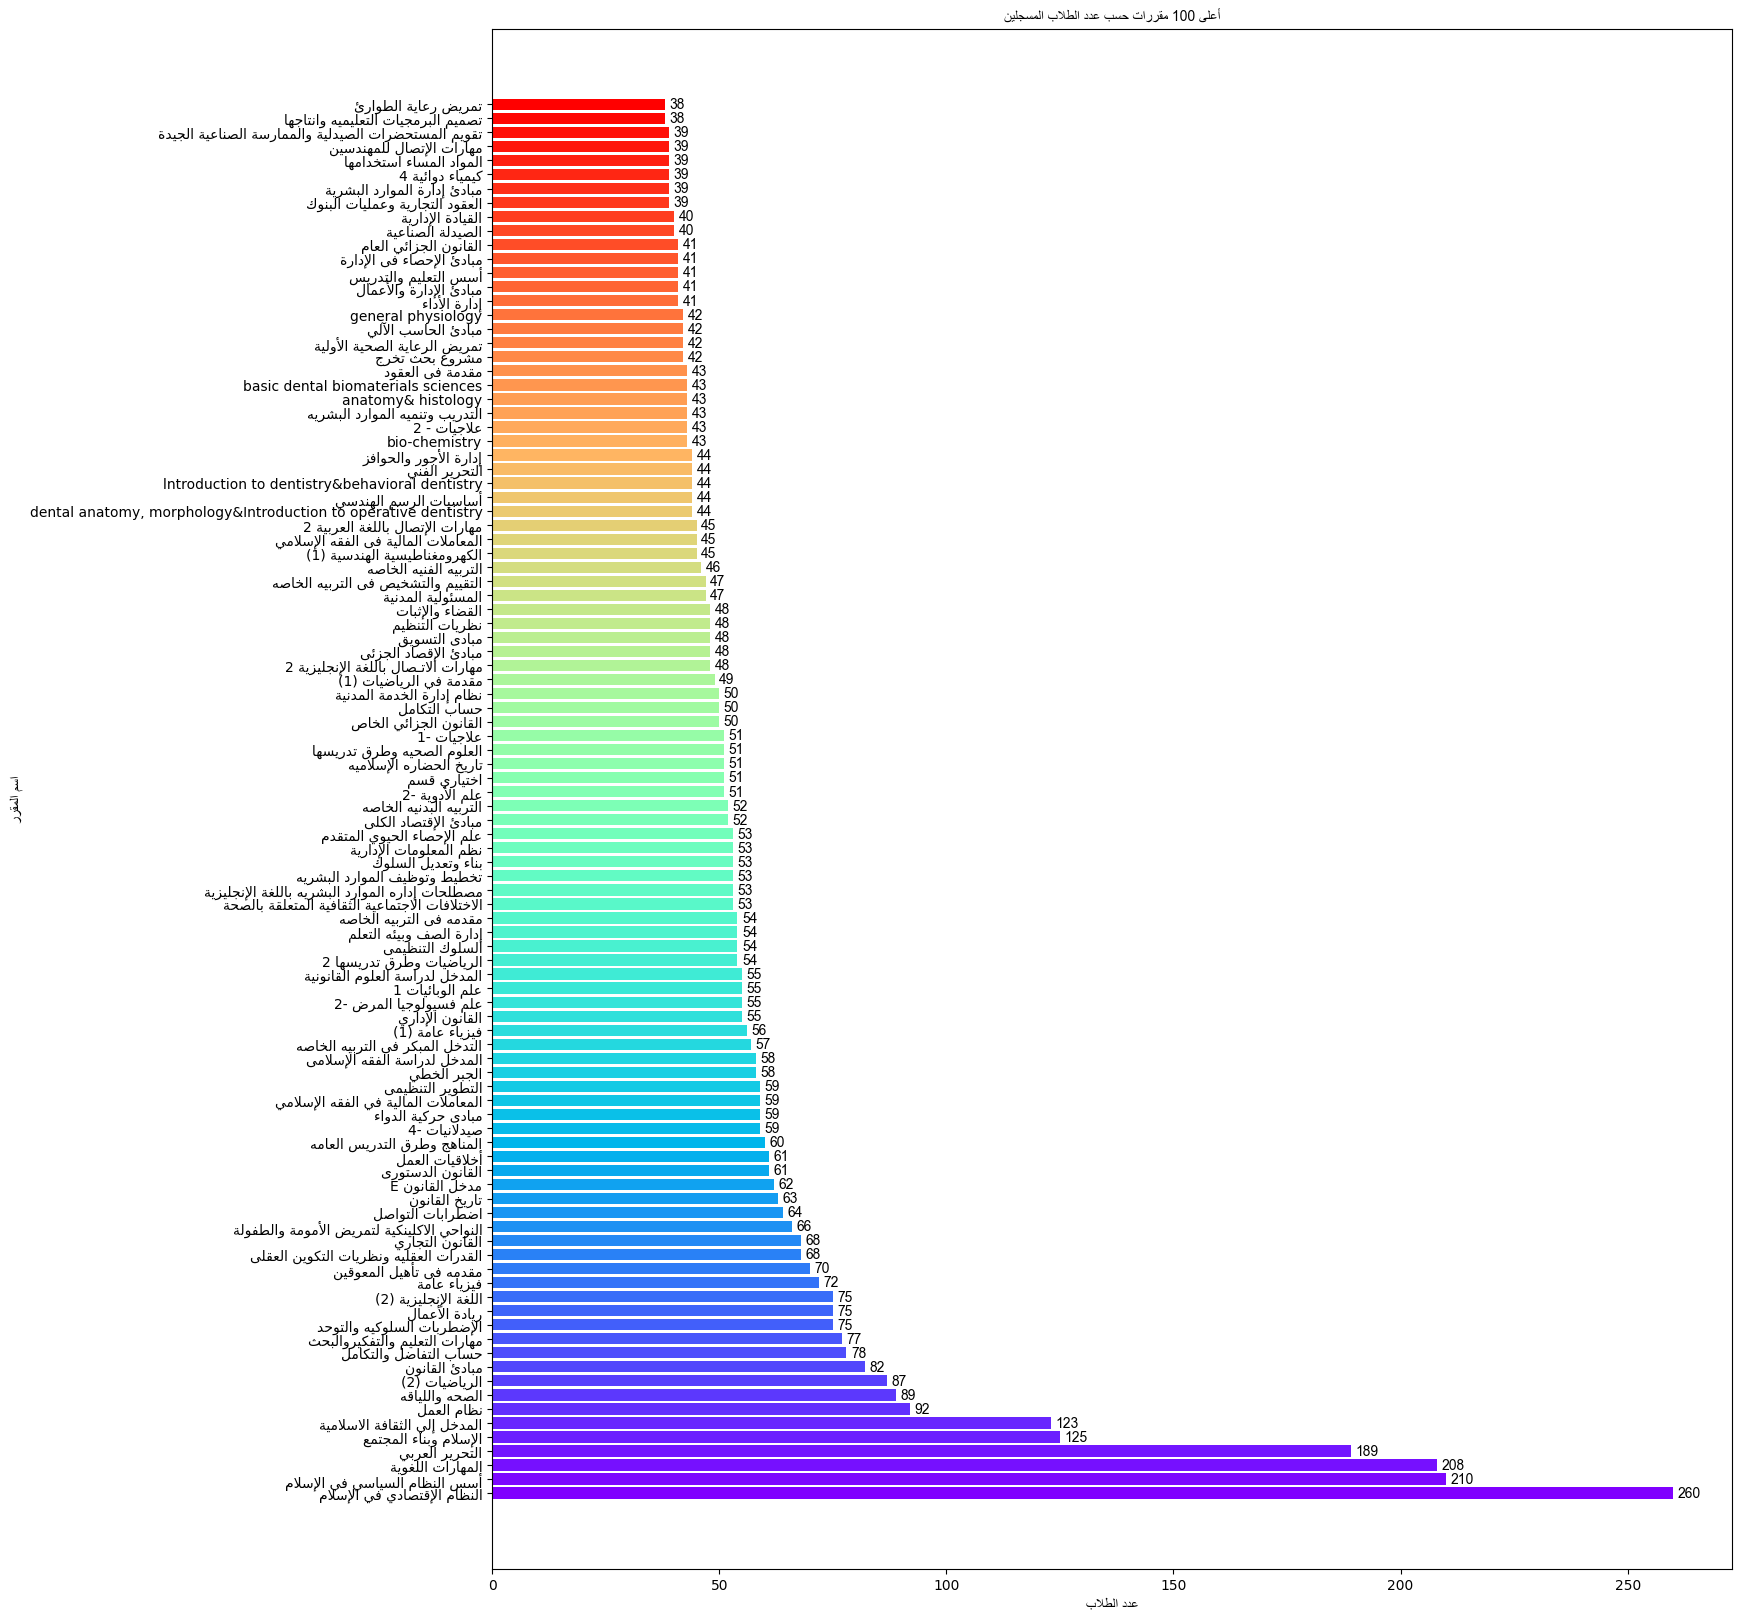

In [34]:
# Data for courses and their student counts
courses = dfs["اسم المقرر"].unique()
students = dfs.groupby("اسم المقرر")["رقم الطالب"].nunique()
Top_100_courses = students.sort_values(ascending=False).head(100)
reshaped = [fix_arabic(course) for course in Top_100_courses.index]

# Create a bar chart with a coloring
plt.figure(figsize=(16, 20))
bars = plt.barh(reshaped, Top_100_courses.values, color=plt.cm.rainbow(np.linspace(0, 1, len(reshaped))))

# Add counts to each bar
for i, (bar, count) in enumerate(zip(bars, Top_100_courses.values)):
    plt.text(count + 1,                # x-position (a little to the right of the bar)
             bar.get_y() + bar.get_height() / 2,  # y-position (middle of the bar)
             str(count),              # text to display
             va='center',             # vertical alignment
             fontproperties=fm.FontProperties(family='Arial'))

# Adding titles and labels
plt.title(fix_arabic('أعلى 100 مقررات حسب عدد الطلاب المسجلين'), fontproperties=fm.FontProperties(family='Arial'))
plt.xlabel(fix_arabic('عدد الطلاب'), fontproperties=fm.FontProperties(family='Arial'))
plt.ylabel(fix_arabic('اسم المقرر'), fontproperties=fm.FontProperties(family='Arial'))

# Display the chart
plt.show()

In [35]:
# show which courses are completely independent and can be scheduled at the same time without any conflicts.
no_conflict_courses = [fix_arabic(node) for node in G.nodes if G.degree(node) == 0]
print(no_conflict_courses)

[]
